# Explore what happens if we permute the labels of the enhancer data

In this notebook, we explore what happens to the feature importance of RF when we permute the labels of the enhancer data. This exploration helps to understand the behavior of Gini importance when RF did not predict well. The finding is interesting: some features are more favored by RF than other features. This highlights the problem of using Gini importance to select "important" features for this dataset.

In [1]:
import rpy2.robjects as robjects
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from irf import irf_utils, irf_jupyter_utils
from scipy.stats import rankdata
from treeinterpreter.feature_importance import feature_importance

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## read the data

In [2]:
tmp = robjects.r['load']('../iRF_analyses/data/enhancer.Rdata')
print(tmp)
X = robjects.r["X"]
XX = np.asarray(X)
print(XX)
assert(len(XX[0]) == X.ncol) #same number of cols
assert(len(XX) == X.nrow)
X = XX
Y = robjects.r["Y"]
Y = np.asarray(Y)
assert(len(Y) == len(X))
test = np.asarray(robjects.r["test.id"])
train = np.asarray(robjects.r["train.id"])
varnames = np.asarray(robjects.r["varnames.all"])

[1] "X"            "Y"            "test.id"      "train.id"     "varnames.all"

[[ 6.      10.      10.      ...  0.       0.       0.     ]
 [ 6.       7.       6.      ...  0.       0.       0.     ]
 [14.       9.      14.      ...  0.       0.       1.2013 ]
 ...
 [ 9.      12.      16.      ...  2.13176  2.22051  1.20134]
 [17.      18.      14.      ...  1.49709  1.39971  1.26398]
 [13.      15.      18.      ...  2.03769  2.03994  0.     ]]


## permute the labels

In [3]:
Y = np.random.permutation(Y)

## train test split

In [4]:
X_train = X[train-1,:]
X_test = X[test-1,:]
y_train = Y[train - 1]
y_test = Y[test - 1]

## train RF

In [10]:
rf = RandomForestClassifier(n_estimators=50, max_depth=5)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

## plot the feature importance

Text(0.5,1,'feature importance of RF after permutation.')

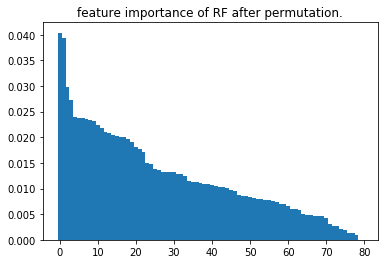

In [11]:
p = len(rf.feature_importances_)
plt.bar(x = list(reversed(range(p))), height = np.sort(rf.feature_importances_), width = 1)
plt.title('feature importance of RF after permutation.')

### repeat the permutation 100 times and record the frequency of the "most important” genes

In [16]:
n_trials = 1
records = []
for _ in range(n_trials):
    y_train = np.random.permutation(y_train)
    rf = RandomForestClassifier(n_estimators=50)
    rf.fit(X_train, y_train)
    records.append(np.argmax(rf.feature_importances_))
vals, freqs = np.unique(records, return_counts=True)

Text(0.5,1,'Relative frequency of being the "most" important feature')

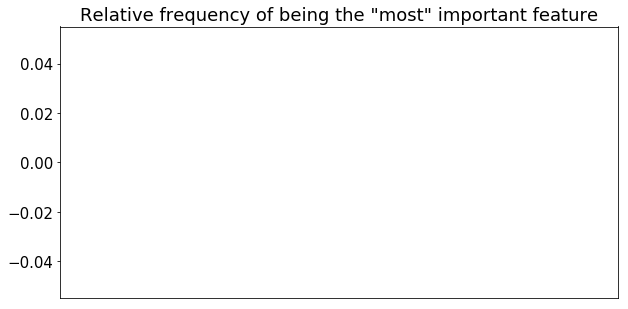

In [17]:
plt.figure(figsize=(10,5))
x = rankdata(freqs, method='ordinal')
plt.bar(x = x[x > 11], height = freqs[x > 11] / 400)
plt.xticks(1+np.arange(11, len(vals)), varnames[1,vals[x > 11]], rotation = 90)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.title('Relative frequency of being the "most" important feature', fontsize=18)

### Findings: even if the labels are permuted, ZLD appears at the top 15% times, H3K18ac appears 25% times, H3K4me1 appears 17% times. This shows the feature importance is not uniform across features when none of them is predictive.

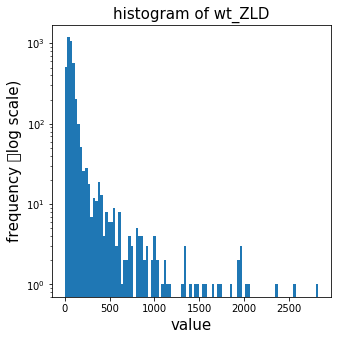

In [20]:
plt.figure(figsize = (5, 5))
plt.hist(X_train[:, np.argmax(rf.feature_importances_)], bins=100)
plt.title('histogram of %s'%(varnames[1, np.argmax(rf.feature_importances_)]), fontsize=15)
plt.xlabel('value', fontsize=15)
plt.ylabel('frequency （log scale)', fontsize=15)
plt.yscale('log')
plt.show()

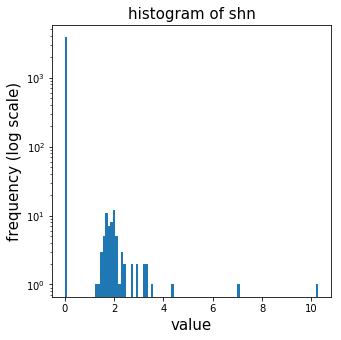

In [19]:
plt.figure(figsize = (5, 5))
plt.hist(X_train[:, np.argmin(rf.feature_importances_)], bins=100)
plt.title('histogram of %s'%(varnames[1, np.argmin(rf.feature_importances_)]), fontsize=15)
plt.xlabel('value', fontsize=15)
plt.ylabel('frequency (log scale)', fontsize=15)
plt.yscale('log')
plt.show()

<hr />

### The result of debiased Gini importance

In [63]:
from sklearn.preprocessing import OneHotEncoder
y_train_one_hot = OneHotEncoder().fit_transform(y_train[:, np.newaxis]).todense()
oob_importance, oob_SE = feature_importance(rf, X_train, y_train_one_hot, type='oob')

Text(0.5,1,'OOB Gini importance with 95% confidence interval')

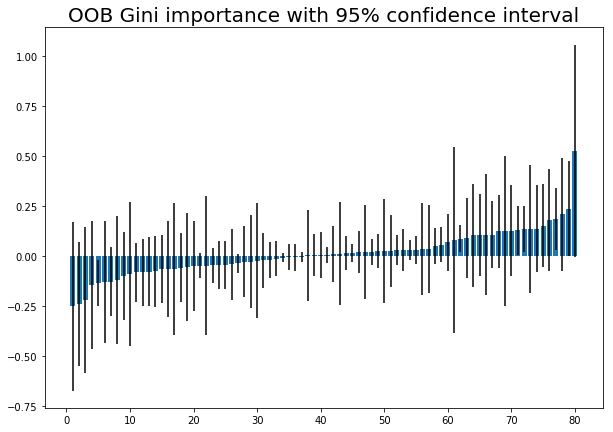

In [71]:
plt.figure(figsize = (10, 7))
plt.bar(x = rankdata(oob_importance, method='ordinal'), height = oob_importance, yerr = oob_SE*2)
plt.title('OOB Gini importance with 95% confidence interval', fontsize = 20)

### Debiased Gini importance

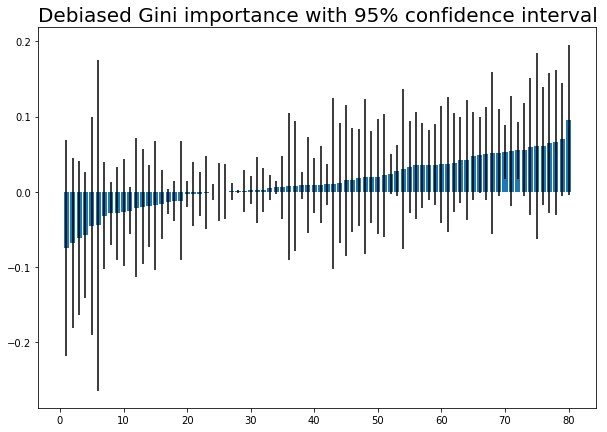

In [74]:
y_test_one_hot = OneHotEncoder().fit(y_train[:, np.newaxis]).transform(y_test[:,np.newaxis]).todense()
test_importance, test_SE = feature_importance(rf, X_test, y_test_one_hot, type='test')
plt.figure(figsize = (10, 7))
plt.bar(x = rankdata(test_importance, method='ordinal'), height = test_importance, yerr = test_SE*2)
plt.title('Debiased Gini importance with 95% confidence interval', fontsize = 20)
plt.show()